In [1]:
import time
start = time.time()

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('octopus_energy_fb_comments.csv')
df.rename(columns={"fb_comment":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,Congratulations Laura
1,1,Rang u as my smart meter ain't working on scre...
2,2,"I just applied switched to Octopus , but can I..."
3,3,What do I need to do to get smart metres...
4,4,Could of phoned me


In [4]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [5]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()
df.reset_index(drop=True,inplace=True)

In [6]:
list_data = df.comments.unique().tolist()

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [9]:
%%time
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Wall time: 1min 12s


In [10]:
%%time
best_model = umap.UMAP(n_components=5,min_dist=0.0).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

Wall time: 10.6 s


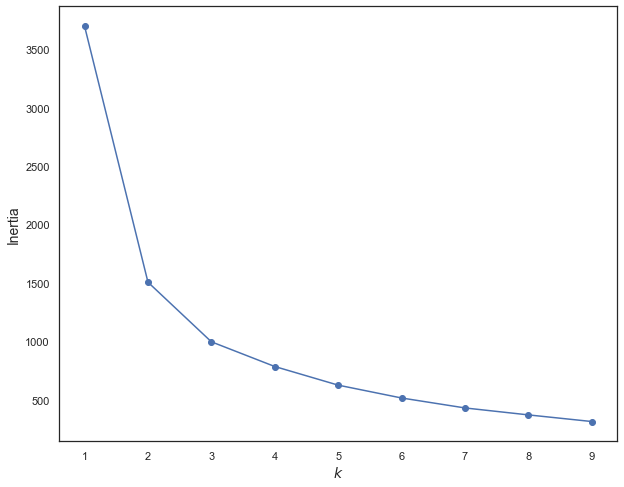

In [11]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [12]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [13]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [14]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [15]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='hsv')
    plt.show()

{-1: 218, 0: 34, 1: 24, 2: 104, 3: 11, 4: 7, 5: 27, 6: 20, 7: 5, 8: 10, 9: 5, 10: 11, 11: 7, 12: 9, 13: 60, 14: 8, 15: 40, 16: 14, 17: 14, 18: 6, 19: 28, 20: 10, 21: 10, 22: 11, 23: 14, 24: 7, 25: 14, 26: 8}


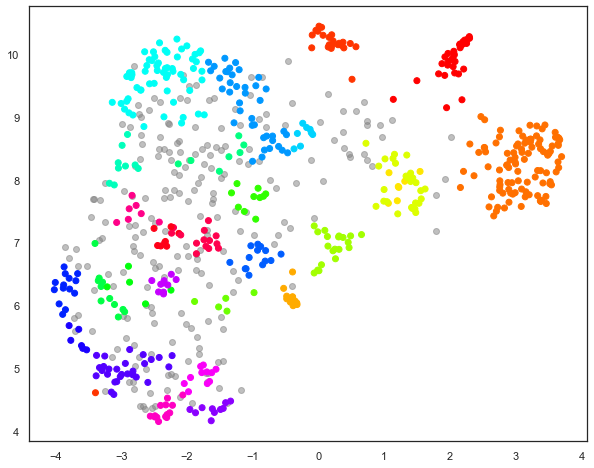

In [16]:
plot()

In [17]:
len(cluster)

736

In [18]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [19]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,ring smart meter work screen for dual fuel sti...
1,0,talk about eagle eye your consumption enter ap...
2,1,your wheel fortune scam you need publish who w...
3,2,congratulation laura lisa maureen jenkin see t...
4,3,clever stuff just need electric car for lol th...
5,4,well do xxx well do winner do have always want...
6,5,fantastic news amazing brilliant what beautifu...
7,6,well do awesome company good energy company st...
8,7,about change energy supplier and interested gr...
9,8,why let submit gas reading online say not inst...


In [20]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 18 	 cluster 19 	 similarity: 0.7849
cluster 23 	 cluster 24 	 similarity: 0.7669
cluster 20 	 cluster 23 	 similarity: 0.7609
cluster 19 	 cluster 20 	 similarity: 0.7549
cluster 26 	 cluster 27 	 similarity: 0.7272
cluster 21 	 cluster 23 	 similarity: 0.7125
cluster 10 	 cluster 22 	 similarity: 0.7080
cluster 20 	 cluster 24 	 similarity: 0.7052
cluster 18 	 cluster 22 	 similarity: 0.7045
cluster 11 	 cluster 24 	 similarity: 0.7044
cluster 10 	 cluster 18 	 similarity: 0.6938
cluster 11 	 cluster 18 	 similarity: 0.6917
cluster 19 	 cluster 22 	 similarity: 0.6914
cluster 19 	 cluster 23 	 similarity: 0.6757
cluster 25 	 cluster 27 	 similarity: 0.6666
cluster 10 	 cluster 11 	 similarity: 0.6618
cluster 11 	 cluster 19 	 similarity: 0.6611
cluster 11 	 cluster 20 	 similarity: 0.6592
cluster 10 	 cluster 19 	 similarity: 0.6530
cluster 18 	 cluster 20 	 similarity: 0.6476
cluster 22 	 cluster 26 	 similarity: 0.6454
cluster 18 	 cluster 23 	 similarity

In [21]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1



Wall time: 89.9 ms


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

,cluster,comments
0,-1,ring smart meter work screen for dual fuel sti...
1,0,talk about eagle eye your consumption enter ap...
2,1,your wheel fortune scam you need publish who w...
3,2,congratulation laura lisa maureen jenkin see t...
4,3,clever stuff just need electric car for lol th...
5,4,well do xxx well do winner do have always want...
6,9,our meter set the wrong serial number the mete...
7,14,you guy have official app get the code easy th...


In [23]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 4 	 cluster 6 	 similarity: 0.3763
cluster 1 	 cluster 2 	 similarity: 0.3555
cluster 2 	 cluster 7 	 similarity: 0.3419
cluster 2 	 cluster 3 	 similarity: 0.3383
cluster 4 	 cluster 7 	 similarity: 0.3367
cluster 2 	 cluster 5 	 similarity: 0.3308
cluster 1 	 cluster 7 	 similarity: 0.3099
cluster 2 	 cluster 6 	 similarity: 0.2938
cluster 1 	 cluster 3 	 similarity: 0.2837
cluster 1 	 cluster 4 	 similarity: 0.2816
cluster 6 	 cluster 7 	 similarity: 0.2639
cluster 3 	 cluster 7 	 similarity: 0.2555
cluster 3 	 cluster 6 	 similarity: 0.2538
cluster 1 	 cluster 6 	 similarity: 0.2136
cluster 2 	 cluster 4 	 similarity: 0.1892
cluster 5 	 cluster 7 	 similarity: 0.1781
cluster 3 	 cluster 5 	 similarity: 0.1442
cluster 3 	 cluster 4 	 similarity: 0.1255
cluster 5 	 cluster 6 	 similarity: 0.1164
cluster 4 	 cluster 5 	 similarity: 0.1028
cluster 1 	 cluster 5 	 similarity: 0.0853
Wall time: 2.2 s


In [24]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1

Wall time: 999 µs


In [25]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,cluster,comments
0,-1,ring smart meter work screen for dual fuel sti...
1,0,talk about eagle eye your consumption enter ap...
2,1,your wheel fortune scam you need publish who w...
3,2,congratulation laura lisa maureen jenkin see t...
4,3,clever stuff just need electric car for lol th...
5,4,well do xxx well do winner do have always want...
6,9,our meter set the wrong serial number the mete...
7,14,you guy have official app get the code easy th...


In [26]:
labeled_docs

,cluster,comments
0,-1,ring smart meter work screen for dual fuel sti...
1,0,talk about eagle eye your consumption enter ap...
2,1,your wheel fortune scam you need publish who w...
3,2,congratulation laura lisa maureen jenkin see t...
4,3,clever stuff just need electric car for lol th...
5,4,well do xxx well do winner do have always want...
6,9,our meter set the wrong serial number the mete...
7,14,you guy have official app get the code easy th...


In [27]:
%%time
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('apple cake', 0.6205), ('apple cookie', 0.5958), ('cake apple', 0.588), ('chocolate cake', 0.5689), ('apple chocolate', 0.5475), ('pie cupcake', 0.5424), ('apple pie', 0.529), ('use cake', 0.5234), ('pie apple', 0.5062), ('apple crumble', 0.4913)]
   Bigram Cluster 2: 
[('scramble quiz', 0.5294), ('enter quiz', 0.5286), ('thankyou quiz', 0.5252), ('awesome quiz', 0.5225), ('great quiz', 0.5132), ('good quiz', 0.5036), ('nice quiz', 0.4673), ('answer prize', 0.4503), ('cos prize', 0.4457), ('catch quiz', 0.4384)]
   Bigram Cluster 3: 
[('tonight programme', 0.5392), ('programme night', 0.4633), ('lisa maureen', 0.4491), ('jenkin tonight', 0.4093), ('prentice william', 0.4061), ('congratulation laura', 0.3959), ('clinton jamie', 0.3856), ('caroline allen', 0.3855), ('kate clinton', 0.3819), ('lisa middleton', 0.3786)]
   Bigram Cluster 4: 
[('electric car', 0.4989), ('obvious electric', 0.4437), ('love electric', 0.4419), ('need electric', 0.438), ('electrician pr

In [28]:
%%time
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('cake', 0.4395), ('cupcake', 0.4134), ('apple', 0.389), ('octocake', 0.3821), ('chocolate', 0.3745), ('cookie', 0.3739), ('pastry', 0.3237), ('cranberry', 0.3095), ('enjoy', 0.2698), ('consumption', 0.2501)]
   Unigram Cluster 2: 
[('prize', 0.3744), ('quiz', 0.352), ('winner', 0.3383), ('award', 0.3162), ('congratulation', 0.3075), ('luck', 0.295), ('thankyou', 0.2885), ('cheer', 0.2822), ('lucky', 0.2815), ('deserve', 0.2668)]
   Unigram Cluster 3: 
[('programme', 0.4025), ('tonight', 0.3734), ('maureen', 0.3503), ('liz', 0.34), ('garnett', 0.3296), ('lisa', 0.3253), ('jess', 0.3216), ('prentice', 0.3212), ('magdalena', 0.3129), ('emma', 0.3064)]
   Unigram Cluster 4: 
[('battery', 0.36), ('electric', 0.3324), ('electrician', 0.3179), ('recyclable', 0.3067), ('expensive', 0.2896), ('car', 0.2829), ('renewable', 0.2607), ('essence', 0.2508), ('obvious', 0.2445), ('engine', 0.2424)]
   Unigram Cluster 5: 
[('winner', 0.391), ('want', 0.2888), ('effort', 0.2862)

In [29]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['cake', 'cupcake', 'apple', 'octocake', 'chocolate', 'cookie', 'pastry', 'cranberry', 'enjoy', 'consumption', 'apple cake', 'apple cookie', 'chocolate cake', 'pie cupcake', 'use cake', 'apple crumble']
   Cluster 2: 
['prize', 'quiz', 'winner', 'award', 'congratulation', 'luck', 'thankyou', 'cheer', 'lucky', 'deserve', 'scramble quiz', 'enter quiz', 'thankyou quiz', 'awesome quiz', 'great quiz', 'good quiz', 'nice quiz', 'answer prize', 'cos prize', 'catch quiz']
   Cluster 3: 
['programme', 'tonight', 'maureen', 'liz', 'garnett', 'lisa', 'jess', 'prentice', 'magdalena', 'emma', 'tonight programme', 'programme night', 'lisa maureen', 'jenkin tonight', 'prentice william', 'congratulation laura', 'clinton jamie', 'caroline allen', 'kate clinton', 'lisa middleton']
   Cluster 4: 
['battery', 'electric', 'electrician', 'recyclable', 'expensive', 'car', 'renewable', 'essence', 'obvious', 'engine', 'electric car', 'obvious electric', 'love electric', 'need electric', 'electri

In [30]:
end = time.time()
print(end - start)

217.65257620811462
